In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import errorbar
import tikzplotlib
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import math
from math import log10, sqrt, inf
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import pickle
from piq import fsim, PieAPP
from torch import tensor
from PIL import Image
import copy

In [2]:
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
plt.style.use('seaborn-v0_8-muted')

In [9]:
seaborn_muted_color_cycle = ['#4878CF', '#6ACC65', '#D65F5F', '#B47CC7', '#C4AD66', '#77BEDB']

In [4]:
timing_data = np.array([[[11.109, 11.446, 11.812],
                         [19.201, 19.431, 19.732],
                         [82.125, 83.166, 85.192],
                         [9.603, 9.792, 10.393],
                         [22.123, 22.409, 22.849],
                         [116.501, 118.558, 118.719]],
                        [[10.287, 11.017, 11.154],
                         [16.519, 16.534, 16.573],
                         [40.759, 40.937, 41.553],
                         [10.353, 10.587, 10.982],
                         [19.128, 19.714, 19.744],
                         [55.408, 56.168, 56.341]]])

In [5]:
timing_data[0,:,1]

array([ 11.446,  19.431,  83.166,   9.792,  22.409, 118.558])

<ErrorbarContainer object of 3 artists>

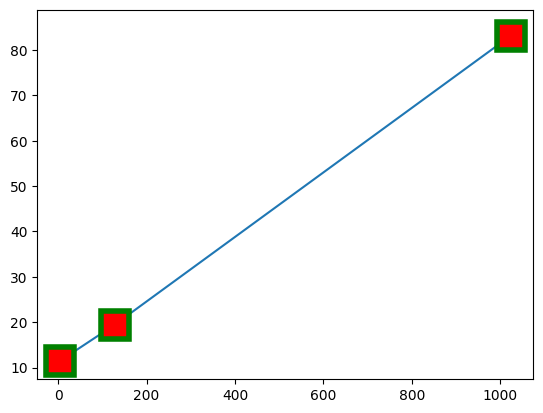

In [5]:
x, y, yerr = [4,128,1024], timing_data[0,:3,1], [timing_data[0,:3,1] - timing_data[0,:3,0], timing_data[0,:3,2] - timing_data[0,:3,1]]
errorbar(x, y, yerr, marker='s', mfc='red',
         mec='green', ms=20, mew=4)

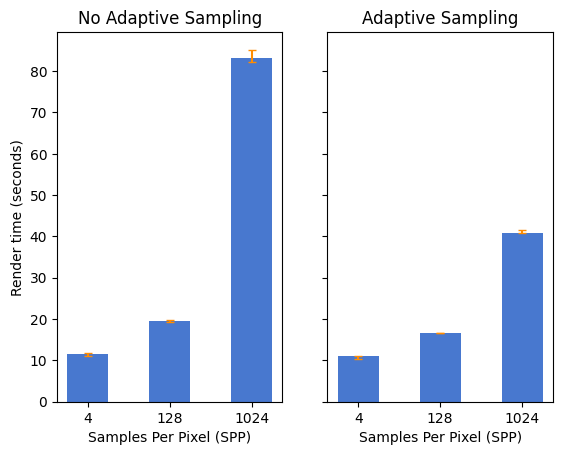

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# plt.subplot(1,2,1)
x, y, yerr = ['4','128','1024'], timing_data[0,:3,1], [timing_data[0,:3,1] - timing_data[0,:3,0], timing_data[0,:3,2] - timing_data[0,:3,1]]
ax1.bar(x, y, width=0.5)
ax1.errorbar(x, y, yerr=yerr, fmt="none", color='darkorange', capsize=3)
ax1.set(xlabel='Samples Per Pixel (SPP)', ylabel='Render time (seconds)')
ax1.set_title('No Adaptive Sampling')

# plt.subplot(1,2,2)
x, y, yerr = ['4','128','1024'], timing_data[1,:3,1], [timing_data[1,:3,1] - timing_data[1,:3,0], timing_data[1,:3,2] - timing_data[1,:3,1]]
ax2.bar(x, y, width=0.5)
ax2.errorbar(x, y, yerr=yerr, fmt="none", color='darkorange', capsize=3)
ax2.set_title('Adaptive Sampling')
ax2.set(xlabel='Samples Per Pixel (SPP)')

tikzplotlib.save("timing_data.tex")

In [6]:
tiling_patterns = np.array([[19.255, 19.675, 21.023],
                            [8.795, 8.892, 9.097],
                            [7.454, 7.504, 7.529],
                            [7.030, 7.136, 7.206]])

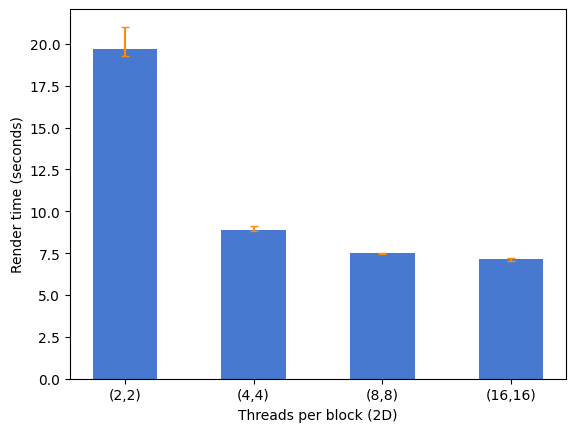

In [7]:
fig, ax = plt.subplots()

tiling_pattern = ('(2,2)', '(4,4)', '(8,8)', '(16,16)')
x, y, yerr = tiling_pattern, tiling_patterns[:,1], np.array([tiling_patterns[:,1] - tiling_patterns[:,0], tiling_patterns[:,2] - tiling_patterns[:,1]])
ax.bar(x, y, width=0.5)
ax.errorbar(x, y, yerr=yerr, fmt="none", color='darkorange', capsize=3)
ax.set_ylabel('Render time (seconds)')
ax.set_xlabel('Threads per block (2D)')

# plt.savefig('tiling_patterns.pgf')
tikzplotlib.save("tiling_patterns.tex")

In [8]:
tiling_patterns = np.array([[201.439, 203.694, 219.737],
                            [92.183, 92.906, 95.289],
                            [70.870, 72.738, 74.702],
                            [75.957, 77.155, 77.988]])

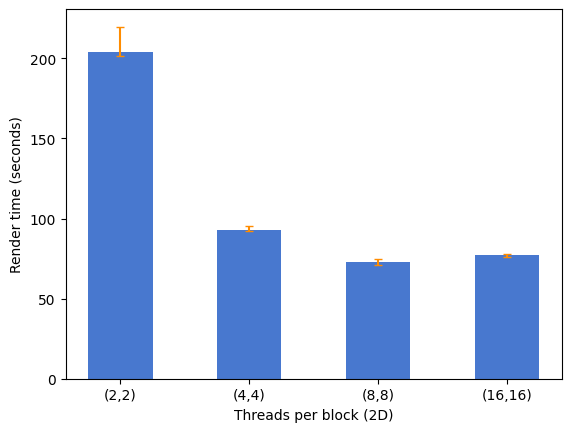

In [9]:
fig, ax = plt.subplots()

tiling_pattern = ('(2,2)', '(4,4)', '(8,8)', '(16,16)')
x, y, yerr = tiling_pattern, tiling_patterns[:,1], np.array([tiling_patterns[:,1] - tiling_patterns[:,0], tiling_patterns[:,2] - tiling_patterns[:,1]])
ax.bar(x, y, width=0.5)
ax.errorbar(x, y, yerr=yerr, fmt="none", color='darkorange', capsize=3)
ax.set_ylabel('Render time (seconds)')
ax.set_xlabel('Threads per block (2D)')

# plt.savefig('tiling_patterns.pgf')
tikzplotlib.save("tiling_patterns2.tex")

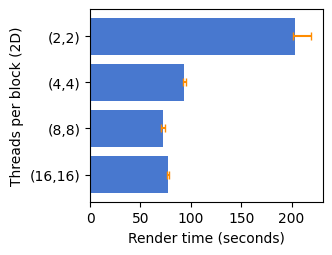

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(3,2.5)

# Example data
tiling_pattern = ('(2,2)', '(4,4)', '(8,8)', '(16,16)')
y_pos = np.arange(len(tiling_pattern))
performance = tiling_patterns[:,1]
error = np.array([tiling_patterns[:,1] - tiling_patterns[:,0], tiling_patterns[:,2] - tiling_patterns[:,1]])

ax.barh(y_pos, performance, xerr=error, align='center', ecolor='darkorange', capsize=3)
ax.set_yticks(y_pos, labels=tiling_pattern)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Render time (seconds)')
ax.set_ylabel('Threads per block (2D)')

tikzplotlib.save("tiling_patterns2.tex")

(1024, 1024, 3)


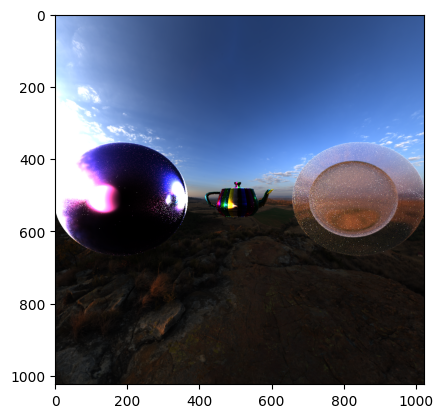

In [7]:
img = cv2.imread('../build/0_ground.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.clip(img, 0, 1)
plt.imshow(img)
print(img.shape)

In [10]:
def PSNR(ground_truth, noisy):
    mse = np.mean((ground_truth - noisy) ** 2, dtype=np.float64)
    if (mse == inf):
        return None
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

(1000, 1000, 3)
361.20199909921956


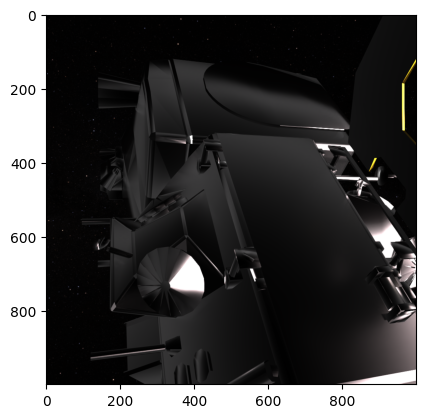

In [6]:
# image_names = ['1_4_off_16.exr', '1_4_on_16.exr', '1_4_off_16_denoised.exr', '1_4_on_16_denoised.exr', '1_128_off_16.exr', '1_128_on_16.exr', '1_128_off_16_denoised.exr', '1_128_on_16_denoised.exr', '1_1024_off_16.exr', '1_1024_on_16.exr', '1_1024_off_16_denoised.exr', '1_1024_on_16_denoised.exr']
image_names = ['2_4_off_16.exr', '2_4_on_16.exr', '2_4_off_16_denoised.exr', '2_4_on_16_denoised.exr', '2_128_off_16.exr', '2_128_on_16.exr', '2_128_off_16_denoised.exr', '2_128_on_16_denoised.exr', '2_1024_off_16.exr', '2_1024_on_16.exr', '2_1024_off_16_denoised.exr', '2_1024_on_16_denoised.exr']
data = []

ground_truth_image = '../build/2_ground_4096_denoised.exr'
img = cv2.imread(ground_truth_image, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.clip(img, 0, 1)
img = img[500:1500, 500:1500, :]
# img = img[850:1150, :300, :]
img[img == -inf] = 0
img[img == inf] = 1
plt.imshow(img)
print(img.shape)
print(cv2.PSNR(img, img))


In [7]:
data = []

for image_name in image_names:
    img_path = '../build/' + image_name
    noisy_img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img = noisy_img[500:1500, 500:1500, :]
    # noisy_img = noisy_img[850:1150, :300, :]
    noisy_img[noisy_img == -inf] = 0
    noisy_img[noisy_img == inf] = 1
    signal_noise_ratios = []
    tile_size = 50
    image_size = 2000
    
    data.append(cv2.PSNR(img, noisy_img))

print(data)
print(len(data))

for i, v in enumerate(data):
    data[i] = round(v, 1)

[67.2321410269968, 67.2321410269968, 79.7653649453705, 79.7653649453705, 78.34343369665012, 78.24313275071044, 89.24672968848043, 88.93500622212221, 87.04293323084137, 84.12331755233232, 94.83423885478986, 90.92461743547845]
12


In [30]:
SPP = ("4", "128", "1024")
psnrs = {
    'No AS, not denoised': (data[0], data[4], data[8]),
    'AS, not denoised': (data[1], data[5], data[9]),
    'No AS, denoised': (data[2], data[6], data[10]),
    'AS, denoised': (data[3], data[7], data[11]),
}

x = np.arange(len(SPP))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

i = 0

for attribute, measurement in psnrs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1
    # if (i - 1) % 4 == 0:
    #     multiplier += 1
    # i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Peak Signal to Noise Ratio (dB)')
ax.set_xticks(x + width + 0.1, SPP)
ax.set_xlabel('Samples Per Pixel (SPP)')
ax.legend(['No AS, not denoised', 'AS, not denoised', 'No AS, denoised', 'AS, denoised'], loc='lower right')

plt.savefig('psnr.pgf')

In [8]:
data = []

for image_name in image_names:
    img_path = '../build/' + image_name
    noisy_img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img = noisy_img[500:1500, 500:1500, :]
    # noisy_img = noisy_img[850:1150, :300, :]
    noisy_img[noisy_img == -inf] = 0
    noisy_img[noisy_img == inf] = 1
    ssims = []
    tile_size = 50
    image_size = 2000
    
    data.append(ssim(img, noisy_img, data_range=noisy_img.max() - noisy_img.min(), channel_axis=2))

print(data)
print(len(data))

for i, v in enumerate(data):
    data[i] = round(v, 2)

[0.57204646, 0.57204646, 0.96671885, 0.96671885, 0.8179, 0.8217973, 0.99395055, 0.99356395, 0.9511464, 0.9212, 0.99785346, 0.99475807]
12


In [33]:
SPP = ("4", "128", "1024")
ssims = {
    'No AS, not denoised': (data[0], data[4], data[8]),
    'AS, not denoised': (data[1], data[5], data[9]),
    'No AS, denoised': (data[2], data[6], data[10]),
    'AS, denoised': (data[3], data[7], data[11]),
}

x = np.arange(len(SPP))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in ssims.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1
    # if (i - 1) % 4 == 0:
    #     multiplier += 1
    # i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Structural Similarity Index Measure (dB)')
ax.set_xticks(x + width + 0.1, SPP)
ax.set_xlabel('Samples Per Pixel (SPP)')
ax.legend(['No AS, not denoised', 'AS, not denoised', 'No AS, denoised', 'AS, denoised'], loc='lower right')

plt.savefig('ssim.pgf')

In [9]:
data = []
img_copy = tensor(img)
img_copy = img_copy.unsqueeze(0)
img_copy = img_copy.permute(0,3,1,2)

for image_name in image_names:
    img_path = '../build/' + image_name
    noisy_img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img = noisy_img[500:1500, 500:1500, :]
    noisy_img_copy = tensor(noisy_img)
    # noisy_img = noisy_img[850:1150, :300, :]
    noisy_img_copy[noisy_img == -inf] = 0
    noisy_img_copy[noisy_img == inf] = 1
    noisy_img_copy = noisy_img_copy.unsqueeze(0)
    noisy_img_copy = noisy_img_copy.permute(0,3,1,2)
    ssims = []
    tile_size = 50
    image_size = 2000
    data.append(fsim(img_copy, noisy_img_copy, data_range=1.))

print(data)
print(len(data))

for i, v in enumerate(data):
    data[i] = round(v.item(), 2)

/home/yash/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[tensor(0.8917), tensor(0.8917), tensor(0.9813), tensor(0.9813), tensor(0.9884), tensor(0.9883), tensor(0.9983), tensor(0.9980), tensor(0.9982), tensor(0.9961), tensor(0.9995), tensor(0.9985)]
12


In [10]:
data = []
img_copy = tensor(img)
img_copy = img_copy.unsqueeze(0)
img_copy = img_copy.permute(0,3,1,2)

for image_name in image_names:
    img_path = '../build/' + image_name
    noisy_img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img = noisy_img[500:1500, 500:1500, :]
    noisy_img_copy = tensor(noisy_img)
    # noisy_img = noisy_img[850:1150, :300, :]
    noisy_img_copy[noisy_img == -inf] = 0
    noisy_img_copy[noisy_img == inf] = 1
    noisy_img_copy = noisy_img_copy.unsqueeze(0)
    noisy_img_copy = noisy_img_copy.permute(0,3,1,2)
    ssims = []
    tile_size = 50
    image_size = 2000
    model = PieAPP()
    model.eval()
    data.append(model(noisy_img_copy, img_copy))

print(data)
print(len(data))

# for i, v in enumerate(data):
#     data[i] = round(v.item(), 2)

[tensor(3.9869), tensor(3.9869), tensor(0.5375), tensor(0.5375), tensor(1.1796), tensor(1.1628), tensor(0.1595), tensor(0.1397), tensor(0.3272), tensor(0.4697), tensor(0.0708), tensor(0.0920)]
12


In [23]:
all_image_names = copy.deepcopy(image_names)
all_image_names.extend(['2_ground_4096.exr', '2_ground_4096_denoised.exr'])

for image_name in all_image_names:
    img_path = '../build/' + image_name
    noisy_img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img = noisy_img[750:1250, 750:1250, :]
    # noisy_img = noisy_img[850:1150, :300, :]
    noisy_img[noisy_img == -inf] = 0
    noisy_img[noisy_img == inf] = 1
    signal_noise_ratios = []
    tile_size = 50
    image_size = 2000
    im = Image.fromarray((noisy_img * 255).astype(np.uint8)) 
    im.save('small_images/' + image_name[:-4] + '.png')

In [70]:
data = []
img_copy = tensor(img)
img_copy = img_copy.unsqueeze(0)
img_copy = img_copy.permute(0,3,1,2)

model = PieAPP()
model.eval()
data.append(model(img_copy, img_copy))

print(data)
print(len(data))

[tensor(-3.7253e-09)]
1


In [67]:
print(data)

[PieAPP(
  (model): PieAPPModel(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv11): Conv2d(512, 512

In [35]:
tiling_filenames = ['log_0_128_off_2_0', 'log_0_128_off_4_0', 'log_0_128_off_8_0', 'log_0_128_off_16_0']
for f in tiling_filenames:
    with open(f, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
    for timestep in dataset:
        print(timestep.keys())
        break
    break

dict_keys(['metrics-daemon/host/cpu_percent (%)/mean', 'metrics-daemon/host/cpu_percent (%)/min', 'metrics-daemon/host/cpu_percent (%)/max', 'metrics-daemon/host/memory_percent (%)/mean', 'metrics-daemon/host/memory_percent (%)/min', 'metrics-daemon/host/memory_percent (%)/max', 'metrics-daemon/host/swap_percent (%)/mean', 'metrics-daemon/host/swap_percent (%)/min', 'metrics-daemon/host/swap_percent (%)/max', 'metrics-daemon/host/memory_used (GiB)/mean', 'metrics-daemon/host/memory_used (GiB)/min', 'metrics-daemon/host/memory_used (GiB)/max', 'metrics-daemon/host/load_average (%) (1 min)/mean', 'metrics-daemon/host/load_average (%) (1 min)/min', 'metrics-daemon/host/load_average (%) (1 min)/max', 'metrics-daemon/host/load_average (%) (5 min)/mean', 'metrics-daemon/host/load_average (%) (5 min)/min', 'metrics-daemon/host/load_average (%) (5 min)/max', 'metrics-daemon/host/load_average (%) (15 min)/mean', 'metrics-daemon/host/load_average (%) (15 min)/min', 'metrics-daemon/host/load_aver

[4.987395459000254, 4.987432102001549, 4.987466928001595, 4.987495421000858, 4.987530237000101, 5.018294471001354, 12.675422838001396, 12.675463784000385, 12.685795715000495, 12.685831321001388, 12.685862091000672, 12.685892049999893, 12.685923022001589, 13.021598793000521, 19.71772959700138, 19.7177677210002, 19.733085392001158, 19.73312291200091, 19.73315795900089, 19.733190560000367, 20.021516969000004, 25.69283774900032, 25.698062090001258, 25.6980974850012, 25.698132580000674, 25.698165542000424, 26.021544936000282]
[13.408000000000001, 13.408000000000001, 13.407999999999998, 13.408, 13.407999999999998, 13.408, 25.503548185763954, 25.50363313597829, 25.511517270566365, 25.511588214991917, 25.51164831529137, 25.511706165050374, 25.511763701633274, 26.14341560907885, 34.337152198041714, 34.33718514283853, 34.340028956226774, 34.34005961418992, 34.34008771768022, 34.34011369970345, 34.56505147148269, 36.814628511039885, 36.80834477161858, 36.80835006817309, 36.80835512265515, 36.8083

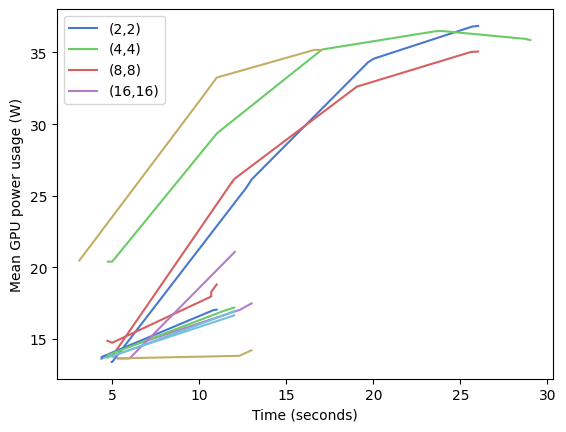

In [13]:
tiling_filenames = ['log_0_128_off_2_0', 'log_0_128_off_2_1', 'log_0_128_off_2_2', 
                    'log_0_128_off_4_0', 'log_0_128_off_4_1', 'log_0_128_off_4_2', 
                    'log_0_128_off_8_0', 'log_0_128_off_8_1', 'log_0_128_off_8_2', 
                    'log_0_128_off_16_0', 'log_0_128_off_16_1', 'log_0_128_off_16_2']

fig, ax = plt.subplots()

for f in tiling_filenames:
    timestamps = []
    related_data = []

    dataset = None

    with open(f, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
    for timestep in range(len(dataset)):
        timestamps.append(dataset[timestep]['metrics-daemon/duration (s)'])
        related_data.append(dataset[timestep]['metrics-daemon/cuda:0 (gpu:0)/power_usage (W)/mean'])

    print(timestamps)
    print(related_data)
    print()

    ax.plot(timestamps, related_data)

ax.legend(['(2,2)', '(4,4)', '(8,8)', '(16,16)'])
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean GPU power usage (W)')

# plt.savefig('power.pgf')
plt.show()

In [11]:
tiling_filenames = ['log_2_256_off_2_128_0', 'log_2_256_off_2_128_1', 'log_2_256_off_2_128_2', 
                    'log_2_256_off_4_64_0', 'log_2_256_off_4_64_1', 'log_2_256_off_4_64_2', 
                    'log_2_256_off_8_32_0', 'log_2_256_off_8_32_1', 'log_2_256_off_8_32_2', 
                    'log_2_256_off_16_16_0', 'log_2_256_off_16_16_1', 'log_2_256_off_16_16_2']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
axes = [ax1, ax2, ax3, ax4]

for i, f in enumerate(tiling_filenames):
    timestamps = []
    related_data = []

    dataset = None

    with open(f, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
    for timestep in range(len(dataset)):
        timestamps.append(dataset[timestep]['time'])
        related_data.append(dataset[timestep]['power'])

    # print(timestamps)
    # print(related_data)
    # print()

    timestamps = timestamps[:100]
    related_data = related_data[:100]

    colors = ['blue', 'green', 'red', 'purple']

    axes[i // 3].plot(timestamps, related_data, color=seaborn_muted_color_cycle[i // 3])

# ax.legend(['(2,2)', '(4,4)', '(8,8)', '(16,16)'])
ax1.set_title('(2,2)')
ax2.set_title('(4,4)')
ax3.set_title('(8,8)')
ax4.set_title('(16,16)')

fig.supxlabel('Time (seconds)')
fig.supylabel('Mean GPU power usage (W)')

fig.tight_layout(pad=1.5)

plt.savefig('power.pgf')
# plt.show()

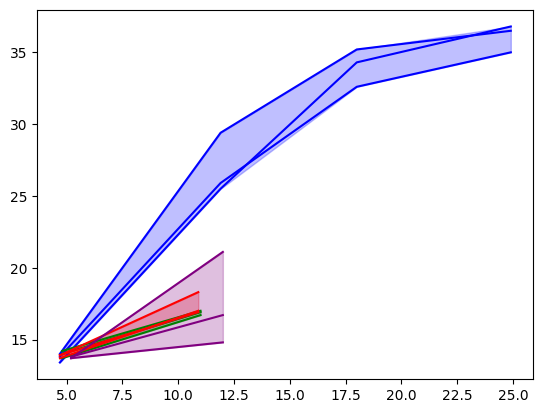

In [19]:
fig, ax = plt.subplots()
time_2 = [4.7, 11.9, 18, 24.9]
data_2_0 = [13.4, 25.5, 34.3, 36.8]
data_2_1 = [14, 29.4, 35.2, 36.5]
data_2_2 = [13.8, 25.9, 32.6, 35]
min_2 = []
max_2 = []
for i, j, k in zip(data_2_0, data_2_1, data_2_2):
    min_2.append(min(i, j, k))
    max_2.append(max(i, j, k))

ax.plot(time_2, data_2_0, color='blue')
ax.plot(time_2, data_2_1, color='blue')
ax.plot(time_2, data_2_2, color='blue')

ax.fill_between(time_2, min_2, max_2, color='blue', alpha=0.25)

time_4 = [4.8, 11]
data_4_0 = [14.2, 17]
data_4_1 = [14, 16.9]
data_4_2 = [13.7, 16.7]
min_4 = [13.7, 16.7]
max_4 = [14.2, 17]

ax.plot(time_4, data_4_0, color='green')
ax.plot(time_4, data_4_1, color='green')
ax.plot(time_4, data_4_2, color='green')

ax.fill_between(time_4, min_4, max_4, color='green', alpha=0.25)

time_8 = [4.7, 10.9]
data_8_0 = [13.7, 17]
data_8_1 = [13.9, 16.9]
data_8_2 = [13.9, 18.3]
min_8 = [13.7, 16.9]
max_8 = [13.9, 18.3]

ax.plot(time_8, data_8_0, color='red')
ax.plot(time_8, data_8_1, color='red')
ax.plot(time_8, data_8_2, color='red')

ax.fill_between(time_8, min_8, max_8, color='red', alpha=0.25)

time_16 = [5.2, 12]
data_16_0 = [13.7, 21.1]
data_16_1 = [13.7, 14.8]
data_16_2 = [13.8, 16.7]
min_16 = [13.7, 14.8]
max_16 = [13.8, 21.1]

ax.plot(time_16, data_16_0, color='purple')
ax.plot(time_16, data_16_1, color='purple')
ax.plot(time_16, data_16_2, color='purple')

ax.fill_between(time_16, min_16, max_16, color='purple', alpha=0.25)

In [24]:
tiling_filenames = ['log_0_128_off_2_0', 'log_0_128_off_4_0', 'log_0_128_off_8_0', 'log_0_128_off_16_0']

fig, ax = plt.subplots()

for f in tiling_filenames:
    timestamps = []
    related_data = []

    dataset = None

    with open(f, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
    for timestep in range(len(dataset)):
        timestamps.append(dataset[timestep]['metrics-daemon/duration (s)'])
        related_data.append(dataset[timestep]['metrics-daemon/cuda:0 (gpu:0)/memory_used (MiB)/max'])

    ax.plot(timestamps, related_data)

ax.legend(['(2,2)', '(4,4)', '(8,8)', '(16,16)'])
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Maximum GPU memory usage (MiB)')

plt.savefig('memory.pgf')

In [18]:
tiling_filenames = ['log_0_128_off_2', 'log_0_128_off_4', 'log_0_128_off_8', 'log_0_128_off_16']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)

ax1.set_xlim(0,30)
ax2.set_xlim(0,30)
ax3.set_xlim(0,30)

ax1.set_title('Run 1')
ax2.set_title('Run 2')
ax3.set_title('Run 3')

for f in tiling_filenames:
    timestamps = [[],[],[]]
    related_data = [[],[],[]]

    dataset = None

    for i in range(3):
        name = f + '_' + str(i)
        with open(name, 'rb') as pickle_file:
            dataset = pickle.load(pickle_file)
        for timestep in range(len(dataset)):
            timestamps[i].append(dataset[timestep]['metrics-daemon/duration (s)'])
            related_data[i].append(dataset[timestep]['metrics-daemon/cuda:0 (gpu:0)/memory_used (MiB)/max'])


    ax1.plot(timestamps[0], related_data[0])
    ax2.plot(timestamps[1], related_data[1])
    ax3.plot(timestamps[2], related_data[2])

fig.legend(['(2,2)', '(4,4)', '(8,8)', '(16,16)'], loc='center right')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Maximum GPU memory usage (MiB)')
ax2.set_xlabel('Time (seconds)')
ax3.set_xlabel('Time (seconds)')

plt.savefig('memory.pgf')

In [50]:
tiling_filenames = ['log_2_256_off_2_128_0', 'log_2_256_off_2_128_1', 'log_2_256_off_2_128_2', 
                    'log_2_256_off_4_64_0', 'log_2_256_off_4_64_1', 'log_2_256_off_4_64_2', 
                    'log_2_256_off_8_32_0', 'log_2_256_off_8_32_1', 'log_2_256_off_8_32_2', 
                    'log_2_256_off_16_16_0', 'log_2_256_off_16_16_1', 'log_2_256_off_16_16_2']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
axes = [ax1, ax2, ax3, ax4]

for i, f in enumerate(tiling_filenames):
    timestamps = []
    related_data = []

    dataset = None

    with open(f, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
    for timestep in range(len(dataset)):
        timestamps.append(dataset[timestep]['time'])
        related_data.append(dataset[timestep]['memory'])

    # print(timestamps)
    # print(related_data)
    # print()

    timestamps = timestamps[:100]
    related_data = related_data[:100]

    colors = ['blue', 'green', 'red', 'purple']

    axes[i // 3].plot(timestamps, related_data, color=seaborn_muted_color_cycle[i // 3])

# ax.legend(['(2,2)', '(4,4)', '(8,8)', '(16,16)'])
ax1.set_title('(2,2)')
ax2.set_title('(4,4)')
ax3.set_title('(8,8)')
ax4.set_title('(16,16)')

fig.supxlabel('Time (seconds)')
fig.supylabel('Mean GPU memory usage (MiB)')

fig.tight_layout(pad=1.5)

plt.savefig('memory.pgf')
# plt.show()